# Psychoinformatics - Week 10 (Examples)
by Tsung-Ren (Tren) Huang (trhuang@g.ntu.edu.tw)

In [7]:
import numpy as np
import numpy.random as rand
import numpy.linalg as la


from matplotlib.pyplot import *
import pylab as plt
import ipywidgets as widgets
from ipywidgets import interact
%matplotlib inline

from sklearn import *

import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter('ignore', DeprecationWarning)

## 0 Double Descent

This example was created by Preetum Nakkiran @ https://windowsontheory.org/2019/12/05/deep-double-descent/ .

While the <a href=https://en.wikipedia.org/wiki/Legendre_polynomials>Legendre polynomials</a> show the double descent phenomenon, <font color=red>the <a href=https://en.wikipedia.org/wiki/Vandermonde_polynomial>Vandermonde polynomials</a> do not</font>. This is because a Legendre polynomial of n degree has a norm of 2/(2n+1) < 1 for all positive integers n:
<img src=https://wikimedia.org/api/rest_v1/media/math/render/svg/4781678915fce2cbbb7add5db352eca4e1cfa71f>

The norm of a function measures how far it deviates from a zeor function. Because a Legendre polynomial of a high n has a norm~0, it contributes little to capture the variance of the ground-truth function (i.e., Y). Because the model fitting here is done by <a href=https://en.wikipedia.org/wiki/Moore%E2%80%93Penrose_inverse>pseudo-inverse</a> and pseudo-inverse prefers a model of the smallest norm, the fitted model will comprise a finite number of low-degree Legendre polynomials.

In [10]:
n = 20
sigma = 0.3 # stdev of noise

def arctan_gt(x):
  return np.arctan(5*x)

def cubic_gt(x):
  return poly(x, np.array([0, -1, 0, 1]), 3)

def relu(x):
  return x*(x >= 0)

#ground_truth = arctan_gt
#ground_truth = relu
ground_truth = cubic_gt

def Vand(x, d):
  ''' Vandermonde matrix for pts x, to degree d '''
  X = np.array([x**i for i in range(0, d+1)]).T
  return X

G = np.polynomial.legendre.legvander # Legendre polynomial basis
#G = Vand # uncomment this to use Vandermonde basis

def poly(pts, beta, d):
  return G(pts, d).dot(beta)

## Compute ground-truth polynomial + noise

x = np.linspace(-1, 1, n)
y = ground_truth(x)
#y += sigma*rand.normal(size=n) # random noise
y += (rand.uniform(size=n) <= 0.2)*sigma # random L0 noise
y -= (rand.uniform(size=n) <= 0.1)*2*sigma # random L0 noise

xdense = np.linspace(-1, 1, 100) # points to plot
xdense = np.sort(np.concatenate((x, xdense))) # add in the sample points explicitly
ygt = ground_truth(xdense)

def solve_reg(A, y, lamb):
  return la.solve(A.T.dot(A) + lamb * np.identity(A.shape[1]), A.T.dot(y))

def run(d, save=False):
  ''' Compute the regressor for degree d, and plot the solution. '''

  betaHat = la.pinv(G(x, d)).dot(y) # unregularized
  #betaHat = solve_reg(G(x, d), y, lamb=0.1)# regularized

  plt.figure(figsize=(7, 7))
  plt.plot(xdense, ygt, label='ground-truth')
  plt.scatter(x, y, c='r', label='samples')
  plt.plot(xdense, poly(xdense, betaHat, d), label='model')
  plt.ylim(-2, 2)
  #plt.axis('off')
  plt.legend()
  if save: plt.savefig('figure.png')
  print('norm: ', la.norm(betaHat))

interact(run, d=widgets.IntSlider(min=1, max=100, step=1, value=n-1));

interactive(children=(IntSlider(value=19, description='d', min=1), Checkbox(value=False, description='save'), …

## 1 Hyperparameter Tuning

### 1.0 The IRIS dataset
<img src="https://upload.wikimedia.org/wikipedia/commons/5/56/Iris_dataset_scatterplot.svg" width=50%>

In [2]:
iris = datasets.load_iris()
X=iris.data
Y=iris.target
print(X)
print(Y)

[[5.1 3.5 1.4 0.2]
 [4.9 3.  1.4 0.2]
 [4.7 3.2 1.3 0.2]
 [4.6 3.1 1.5 0.2]
 [5.  3.6 1.4 0.2]
 [5.4 3.9 1.7 0.4]
 [4.6 3.4 1.4 0.3]
 [5.  3.4 1.5 0.2]
 [4.4 2.9 1.4 0.2]
 [4.9 3.1 1.5 0.1]
 [5.4 3.7 1.5 0.2]
 [4.8 3.4 1.6 0.2]
 [4.8 3.  1.4 0.1]
 [4.3 3.  1.1 0.1]
 [5.8 4.  1.2 0.2]
 [5.7 4.4 1.5 0.4]
 [5.4 3.9 1.3 0.4]
 [5.1 3.5 1.4 0.3]
 [5.7 3.8 1.7 0.3]
 [5.1 3.8 1.5 0.3]
 [5.4 3.4 1.7 0.2]
 [5.1 3.7 1.5 0.4]
 [4.6 3.6 1.  0.2]
 [5.1 3.3 1.7 0.5]
 [4.8 3.4 1.9 0.2]
 [5.  3.  1.6 0.2]
 [5.  3.4 1.6 0.4]
 [5.2 3.5 1.5 0.2]
 [5.2 3.4 1.4 0.2]
 [4.7 3.2 1.6 0.2]
 [4.8 3.1 1.6 0.2]
 [5.4 3.4 1.5 0.4]
 [5.2 4.1 1.5 0.1]
 [5.5 4.2 1.4 0.2]
 [4.9 3.1 1.5 0.2]
 [5.  3.2 1.2 0.2]
 [5.5 3.5 1.3 0.2]
 [4.9 3.6 1.4 0.1]
 [4.4 3.  1.3 0.2]
 [5.1 3.4 1.5 0.2]
 [5.  3.5 1.3 0.3]
 [4.5 2.3 1.3 0.3]
 [4.4 3.2 1.3 0.2]
 [5.  3.5 1.6 0.6]
 [5.1 3.8 1.9 0.4]
 [4.8 3.  1.4 0.3]
 [5.1 3.8 1.6 0.2]
 [4.6 3.2 1.4 0.2]
 [5.3 3.7 1.5 0.2]
 [5.  3.3 1.4 0.2]
 [7.  3.2 4.7 1.4]
 [6.4 3.2 4.5 1.5]
 [6.9 3.1 4.

['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']


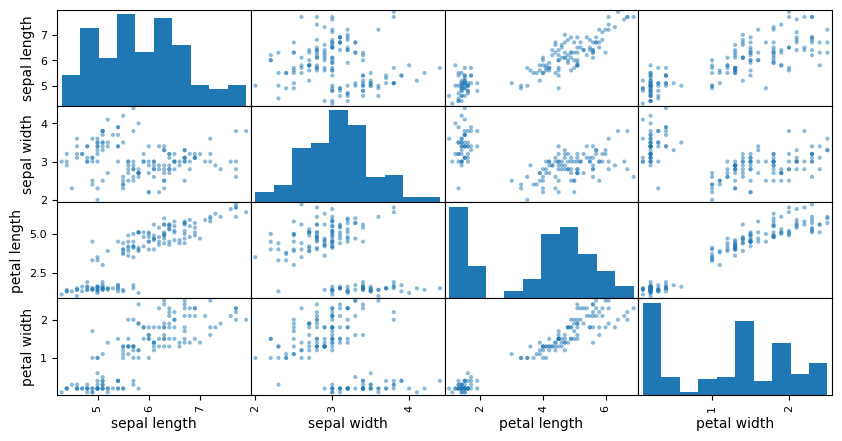

In [3]:
import pandas as pd
print(iris.feature_names)
df = pd.DataFrame(X, columns=['sepal length','sepal width','petal length','petal width'])
pd.plotting.scatter_matrix(df, figsize=(10,5));

In [4]:
iris.feature_names

['sepal length (cm)',
 'sepal width (cm)',
 'petal length (cm)',
 'petal width (cm)']

### 1.1 Support Vector Classifier

In [5]:
sss=model_selection.StratifiedShuffleSplit(n_splits=5,test_size=0.1)
for train_index, test_index in sss.split(X, Y):
    print('Training-Testing overlaps:',set(train_index).intersection(test_index))
    X_train, X_test = X[train_index], X[test_index]
    Y_train, Y_test = Y[train_index], Y[test_index]
    print("Y_train:",sum(Y_train==0),sum(Y_train==1),sum(Y_train==2),"Y_test",sum(Y_test==0),sum(Y_test==1),sum(Y_test==2),'\n')

Training-Testing overlaps: set()
Y_train: 45 45 45 Y_test 5 5 5 

Training-Testing overlaps: set()
Y_train: 45 45 45 Y_test 5 5 5 

Training-Testing overlaps: set()
Y_train: 45 45 45 Y_test 5 5 5 

Training-Testing overlaps: set()
Y_train: 45 45 45 Y_test 5 5 5 

Training-Testing overlaps: set()
Y_train: 45 45 45 Y_test 5 5 5 



In [12]:
acc=[]
for train_index, test_index in sss.split(X, Y):
    X_train, X_test = X[train_index], X[test_index]
    Y_train, Y_test = Y[train_index], Y[test_index]
    model=svm.SVC(C=10)
    model.fit(X_train[:,0:2],Y_train) #training
    acc.append(model.predict(X_test[:,0:2])==Y_test) #testing
print(np.mean(acc))

0.8


### 1.2 Grid Search (Exhaustive Search)

In [5]:
C=[10**i for i in range(-7,7)]
print(C)

[1e-07, 1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000, 1000000]


-6 -5 -4 -3 -2 -1 0 1 2 3 4 5 Search time: 0.36093902587890625
[0.7733333333333334, 0.72, 0.72, 0.7866666666666665, 0.8000000000000002, 0.7866666666666667, 0.8266666666666665, 0.8133333333333332, 0.8133333333333332, 0.7733333333333333, 0.76, 0.8266666666666665]


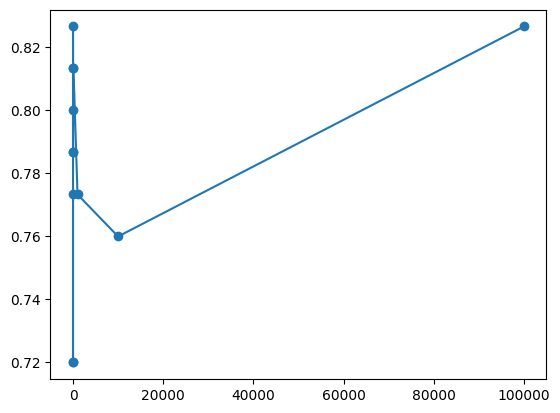

In [13]:
import time
xx=[]
yy=[]
t0=time.time()
for i in range(-6,6):
    print(i,end=' ')
    xx.append(10**i)
    acc=[]
    for train_index, test_index in sss.split(X, Y):
        X_train, X_test = X[train_index], X[test_index]
        Y_train, Y_test = Y[train_index], Y[test_index]
        model=svm.SVC(C=xx[-1]) # tuning the hyperparameter C
        model.fit(X_train[:,0:2],Y_train) #training
        acc.append(np.mean(model.predict(X_test[:,0:2])==Y_test)) #testing
    yy.append(np.mean(acc))
print('Search time:', time.time()-t0)
print(yy)
plot(xx,yy,'o-');

In [27]:
model=svm.SVC()
parameters={'C':[10**i for i in range(-6,6)]}
clf=model_selection.GridSearchCV(model, parameters, cv=5) #Try RandomizedSearchCV()
clf.fit(X[:,0:2], Y)
print('C:',clf.cv_results_['param_C'])
print('Mean Test Score:',clf.cv_results_['mean_test_score'])
print('Best C:',clf.best_params_)

C: [1e-06 1e-05 0.0001 0.001 0.01 0.1 1 10 100 1000 10000 100000]
Mean Test Score: [0.78666667 0.78666667 0.78666667 0.78666667 0.78666667 0.77333333
 0.82       0.81333333 0.81333333 0.78666667 0.78       0.75333333]
Best C: {'C': 1}


### 1.3 HyperOpt (Bayesian Optimization)

In [16]:
#!pip install git+https://github.com/hyperopt/hyperopt.git
from hyperopt import fmin, tpe, rand, hp

def F(x):
    return(x**2)

best_x = fmin(fn=F,
    space=hp.uniform('x', -6, 6),
    algo=rand.suggest,
    max_evals=1000)
print(best_x)

100%|█| 1000/1000 [00:00<00:00, 2198.30trial/s, best loss: 9.999245975398551e-05
{'x': -0.009999622980592093}


In [17]:
import time

def F(x):
    acc=[]
    for train_index, test_index in sss.split(X, Y):
        X_train, X_test = X[train_index], X[test_index]
        Y_train, Y_test = Y[train_index], Y[test_index]
        model=svm.SVC(C=10**x) # tuning the hyperparameter C
        model.fit(X_train[:,0:2],Y_train) #training
        acc.append(np.mean(model.predict(X_test[:,0:2])==Y_test)) #testing
    return(1-np.mean(acc)) # error

t0=time.time()
best_x = fmin(fn=F,
    space=hp.uniform('x', -5, 5),
    algo=tpe.suggest, # try rand.suggest
    max_evals=100)
print('Search Time:',time.time()-t0)
print(best_x)

100%|██████| 100/100 [00:01<00:00, 68.43trial/s, best loss: 0.09333333333333338]
Search Time: 1.4651687145233154
{'x': -0.15030910625174365}


### 1.4 HyperBand
!! This package is not working for Tren in 2023 !! 

!! Neither do https://github.com/thuijskens/scikit-hyperband !!

In [10]:
#!pip install git+https://github.com/civisanalytics/civisml-extensions
from civismlext.hyperband import HyperbandSearchCV
model = svm.SVC()
print(model.get_params().keys())

clf = HyperbandSearchCV(
    model,
    param_distributions={'C': [10**i for i in np.arange(-10,10,0.1)]},
    cost_parameter_max={'max_iter': -1},
    cost_parameter_min={'max_iter': -1})
clf.fit(X[:,0:2],Y)

print(clf.best_params_)
print(clf.best_score_)

dict_keys(['C', 'break_ties', 'cache_size', 'class_weight', 'coef0', 'decision_function_shape', 'degree', 'gamma', 'kernel', 'max_iter', 'probability', 'random_state', 'shrinking', 'tol', 'verbose'])
{'C': 630957.3444801117, 'max_iter': -1}
0.7333333333333333


## 2 Ensemble Learning

### 2.0 Decision Tree

In [18]:
skf=model_selection.StratifiedKFold(n_splits=5,shuffle=True)
for train_index, test_index in skf.split(X, Y):
    print('Training-Testing overlaps:',set(train_index).intersection(test_index))
    X_train, X_test = X[train_index], X[test_index]
    Y_train, Y_test = Y[train_index], Y[test_index]
    print("Y_train:",sum(Y_train==0),sum(Y_train==1),sum(Y_train==2),"Y_test",sum(Y_test==0),sum(Y_test==1),sum(Y_test==2),'\n')

Training-Testing overlaps: set()
Y_train: 40 40 40 Y_test 10 10 10 

Training-Testing overlaps: set()
Y_train: 40 40 40 Y_test 10 10 10 

Training-Testing overlaps: set()
Y_train: 40 40 40 Y_test 10 10 10 

Training-Testing overlaps: set()
Y_train: 40 40 40 Y_test 10 10 10 

Training-Testing overlaps: set()
Y_train: 40 40 40 Y_test 10 10 10 



In [19]:
acc=[]
for train_index, test_index in skf.split(X, Y):
    X_train, X_test = X[train_index], X[test_index]
    Y_train, Y_test = Y[train_index], Y[test_index]
    model=tree.DecisionTreeClassifier()
    model.fit(X_train[:,0:2],Y_train) #training
    acc.append(model.predict(X_test[:,0:2])==Y_test) #testing
print(np.mean(acc))

0.7133333333333334


### 2.1 Random Forest

In [20]:
skf=model_selection.StratifiedKFold(n_splits=5,shuffle=True)
acc=[]
for train_index, test_index in skf.split(X, Y):
    X_train, X_test = X[train_index], X[test_index]
    Y_train, Y_test = Y[train_index], Y[test_index]
    model=ensemble.RandomForestClassifier(n_estimators=100, max_depth=2)
    model.fit(X_train[:,0:2],Y_train) #training
    acc.append(model.predict(X_test[:,0:2])==Y_test) #testing
print(np.mean(acc))

0.7666666666666667


In [29]:
model=ensemble.RandomForestClassifier()

parameters = {
    'max_depth': [3, None],
    'max_features': [1, 2, 3],
    'criterion': ['gini', 'entropy'],
    'bootstrap': [True, False]
}

clf=model_selection.RandomizedSearchCV(model, parameters, cv=5)
clf.fit(X[:,0:2],Y)

print(clf.best_params_)
print(clf.best_score_)

{'max_features': 1, 'max_depth': 3, 'criterion': 'gini', 'bootstrap': True}
0.8


### 2.2 Bagging (Bootstrap Aggregating)

In [31]:
acc=[]
for train_index, test_index in skf.split(X, Y):
    X_train, X_test = X[train_index], X[test_index]
    Y_train, Y_test = Y[train_index], Y[test_index]
    model=ensemble.BaggingClassifier(tree.DecisionTreeClassifier(max_depth=1),max_samples=1.0, max_features=1.0, n_estimators=100)
    #model=ensemble.BaggingClassifier(svm.SVC(0.1),max_samples=1.0, max_features=1.0, n_estimators=100)
    model.fit(X_train[:,0:2],Y_train) #training
    acc.append(model.predict(X_test[:,0:2])==Y_test) #testing
print(np.mean(acc))

0.6666666666666666


### 2.3 Boosting

#### 2.3.1 AdaBoost

In [32]:
acc=[]
for train_index, test_index in skf.split(X, Y):
    X_train, X_test = X[train_index], X[test_index]
    Y_train, Y_test = Y[train_index], Y[test_index]
    #model=ensemble.AdaBoostClassifier(svm.SVC(0.1),n_estimators=100,algorithm="SAMME")
    model=ensemble.AdaBoostClassifier(tree.DecisionTreeClassifier(max_depth=1),n_estimators=100,algorithm="SAMME")
    model.fit(X_train[:,0:2],Y_train) #training
    acc.append(model.predict(X_test[:,0:2])==Y_test) #testing
print(np.mean(acc))

0.6933333333333334


#### 2.3.2 Gradient Boosting

The following two implementations are conceptually identical but XGBoost is more resource-efficient and can be parallelized/distributed.

##### 2.3.2.1 Scikit-learn's Gradient Tree Boosting

In [33]:
acc=[]
for train_index, test_index in skf.split(X, Y):
    X_train, X_test = X[train_index], X[test_index]
    Y_train, Y_test = Y[train_index], Y[test_index]
    model=ensemble.GradientBoostingClassifier(max_depth=1, n_estimators=1000)
    model.fit(X_train[:,0:2],Y_train) #training
    acc.append(model.predict(X_test[:,0:2])==Y_test) #testing
print(np.mean(acc))

0.7133333333333334


##### 2.3.2.2 XGBoost (eXtreme Gradient Boosting)

In [34]:
#!conda install -c conda-forge xgboost 
import xgboost

acc=[]
for train_index, test_index in skf.split(X, Y):
    X_train, X_test = X[train_index], X[test_index]
    Y_train, Y_test = Y[train_index], Y[test_index]
    model=xgboost.XGBClassifier(n_estimators=1000, use_label_encoder=False, eval_metric='mlogloss')
    model.fit(X_train[:,0:2],Y_train) #training
    acc.append(model.predict(X_test[:,0:2])==Y_test) #testing
print(np.mean(acc))

0.6866666666666666
